In [1]:
from ensemble_functions import *

In [2]:
training_data = pd.read_parquet('training_data.parquet')
training_data.head()

año  mes  dia  hora  dia_semana  holiday  \
datetime                                                         
2022-01-01 00:00:00  2022    1    1     0           6        1   
2022-01-01 01:00:00  2022    1    1     1           6        1   
2022-01-01 02:00:00  2022    1    1     2           6        1   
2022-01-01 03:00:00  2022    1    1     3           6        1   
2022-01-01 04:00:00  2022    1    1     4           6        1   

                     temperature_2m  rain  relative_humidity_2m  snowfall  \
datetime                                                                    
2022-01-01 00:00:00        8.508500   0.0             97.987221       0.0   
2022-01-01 01:00:00        9.308500   0.0             95.387932       0.0   
2022-01-01 02:00:00        8.158501   0.0             97.981651       0.0   
2022-01-01 03:00:00        8.208500   0.0             99.323456       0.0   
2022-01-01 04:00:00        7.808500   0.0            100.000000       0.0   

                     Bronx  Brooklyn  Manhattan  Queens  Staten Island  
datetime                                                                
2022-01-01 00:00:00   4122      8977      16146    5279            266  
2022-01-01 01:00:00   4460      8572      13563    5475            282  
2022-01-01 02:00:00   4253      8785      12271    5293            364  
2022-01-01 03:00:00   3671      8341      11369    4674            352  
2022-01-01 04:00:00   2544      5628       6912    3652            220

In [3]:
ensemble, ensemble_predictions, ensemble_errors, ponderacion = train_ensemble(data=training_data, verbose=1, file='ensemble_1.joblib')

Comienzo del entrenamiento del ensemble
Inicio de construcción modelo LSTM


88/88 [==============================] - 0s 3ms/step
Finalizada la construcción de LSTM
RMSE por distrito:
{'Bronx': 340.5677192858899, 'Brooklyn': 917.3949618868984, 'Manhattan': 2564.361634455092, 'Queens': 591.1799927300443, 'Staten Island': 54.67604707493718}
Inicio de construcción modelo RF
Inicio de evaluación de Bronx
Mejores Hiperparámetros: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 150}
RMSE: 322.5181632969083
-----------------------------------------------------------------------------------------
Inicio de evaluación de Brooklyn
Mejores Hiperparámetros: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
RMSE: 735.7777706862355
-----------------------------------------------------------------------------------------
Inicio de evaluación de Manhattan
Mejores Hiperparámetros: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
RMSE: 1420.814886784879
-----------

INFO:tensorflow:Assets written to: C:\Users\alter\AppData\Local\Temp\tmpevw77n5u\assets


Ponderacion: lineal
110/110 [==============================] - 0s 3ms/step
Distrito: Bronx
RMSE: 412.4998812647599
Distrito: Brooklyn
RMSE: 924.261679806066
Distrito: Manhattan
RMSE: 1728.4709457296337
Distrito: Queens
RMSE: 715.549562259876
Distrito: Staten Island
RMSE: 67.30500716671342
Ponderacion: exp Alpha: 0.001
110/110 [==============================] - 0s 3ms/step
Distrito: Bronx
RMSE: 412.54832967936574
Distrito: Brooklyn
RMSE: 922.130694799246
Distrito: Manhattan
RMSE: 1772.016538427535
Distrito: Queens
RMSE: 713.6092192144997
Distrito: Staten Island
RMSE: 67.32434407362814
Ponderacion: exp Alpha: 0.01
110/110 [==============================] - 0s 3ms/step
Distrito: Bronx
RMSE: 410.90656574588587
Distrito: Brooklyn
RMSE: 919.3514119077298
Distrito: Manhattan
RMSE: 1897.160592141573
Distrito: Queens
RMSE: 674.1478164061997
Distrito: Staten Island
RMSE: 67.28927498182239
Ponderacion: exp Alpha: 0.1
110/110 [==============================] - 0s 3ms/step
Distrito: Bronx
RMSE: 418

In [4]:
ponderacion

{'tipo': 'lineal', 'alpha': 1}

In [6]:
exportar_modelo(ensemble, ensemble_predictions, ensemble_errors, ponderacion, archivo='ensemble_1_complete.joblib')

INFO:tensorflow:Assets written to: C:\Users\alter\AppData\Local\Temp\tmpn2q_rm67\assets


INFO:tensorflow:Assets written to: C:\Users\alter\AppData\Local\Temp\tmpn2q_rm67\assets


Modelo exportado: ensemble_1_complete.joblib


In [2]:
ensemble_completo = load('ensemble_1_complete.joblib')

In [4]:
ensemble_completo['ponderacion']

{'tipo': 'lineal', 'alpha': 1}

In [6]:
pred = ensemble_completo['ensemble_predictions']['lineal']

In [7]:
def graficar_pred_ensemble(pred, numero_dias=5):
    
    for district in pred.keys():
        plt.figure(figsize=(12,12))
        sns.set_style('darkgrid')
        sns.lineplot(pred[district]['Predicted'][:24*numero_dias], label='Predicted values', color='blue')
        sns.lineplot(pred[district]['Real values'][:24*numero_dias], label='Real values', color='green')
        plt.title(f'Pedicciones de demanda en {district} utilizando Weighted Ensemble', fontsize=14)
        plt.xlabel('Fecha-hora', fontsize=12)
        plt.ylabel('Demanda', fontsize=12)
        plt.legend(fontsize=10)
        plt.tight_layout()
        plt.show()

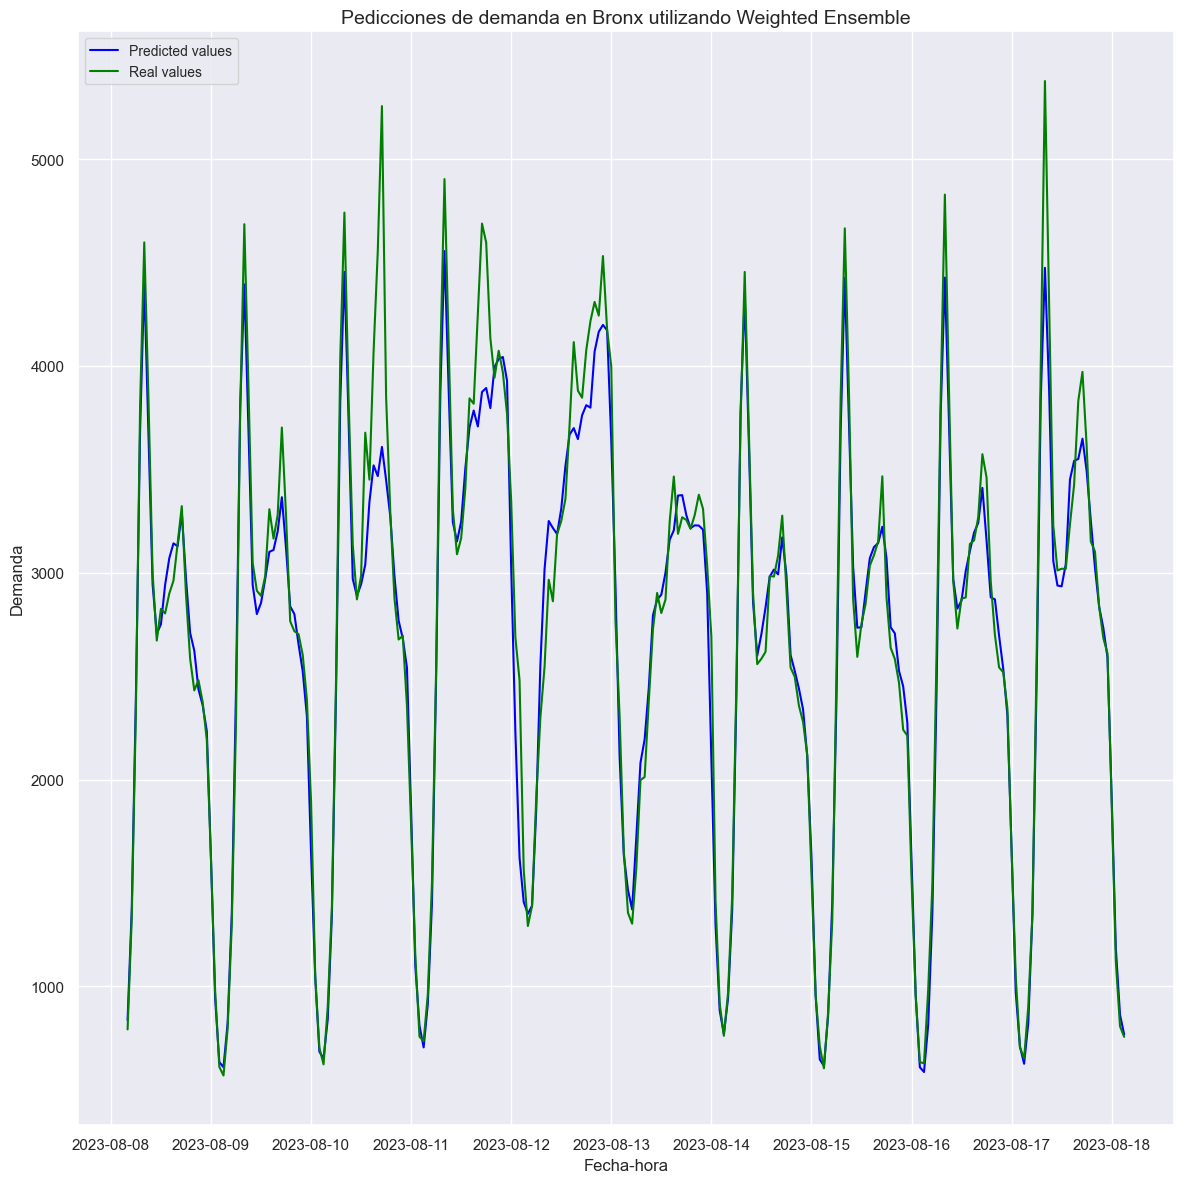

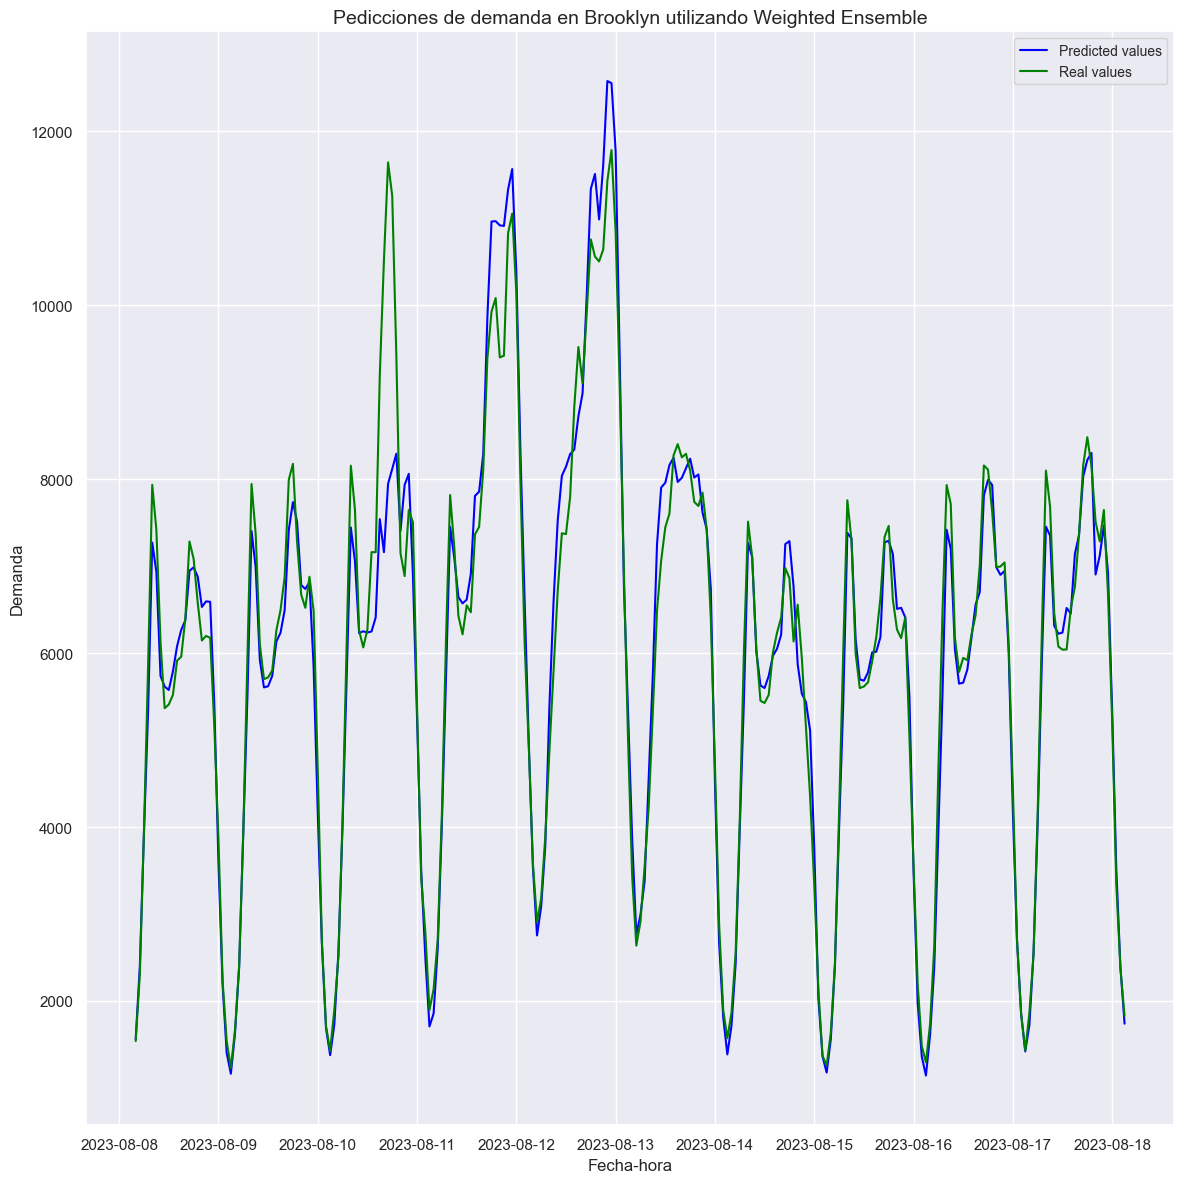

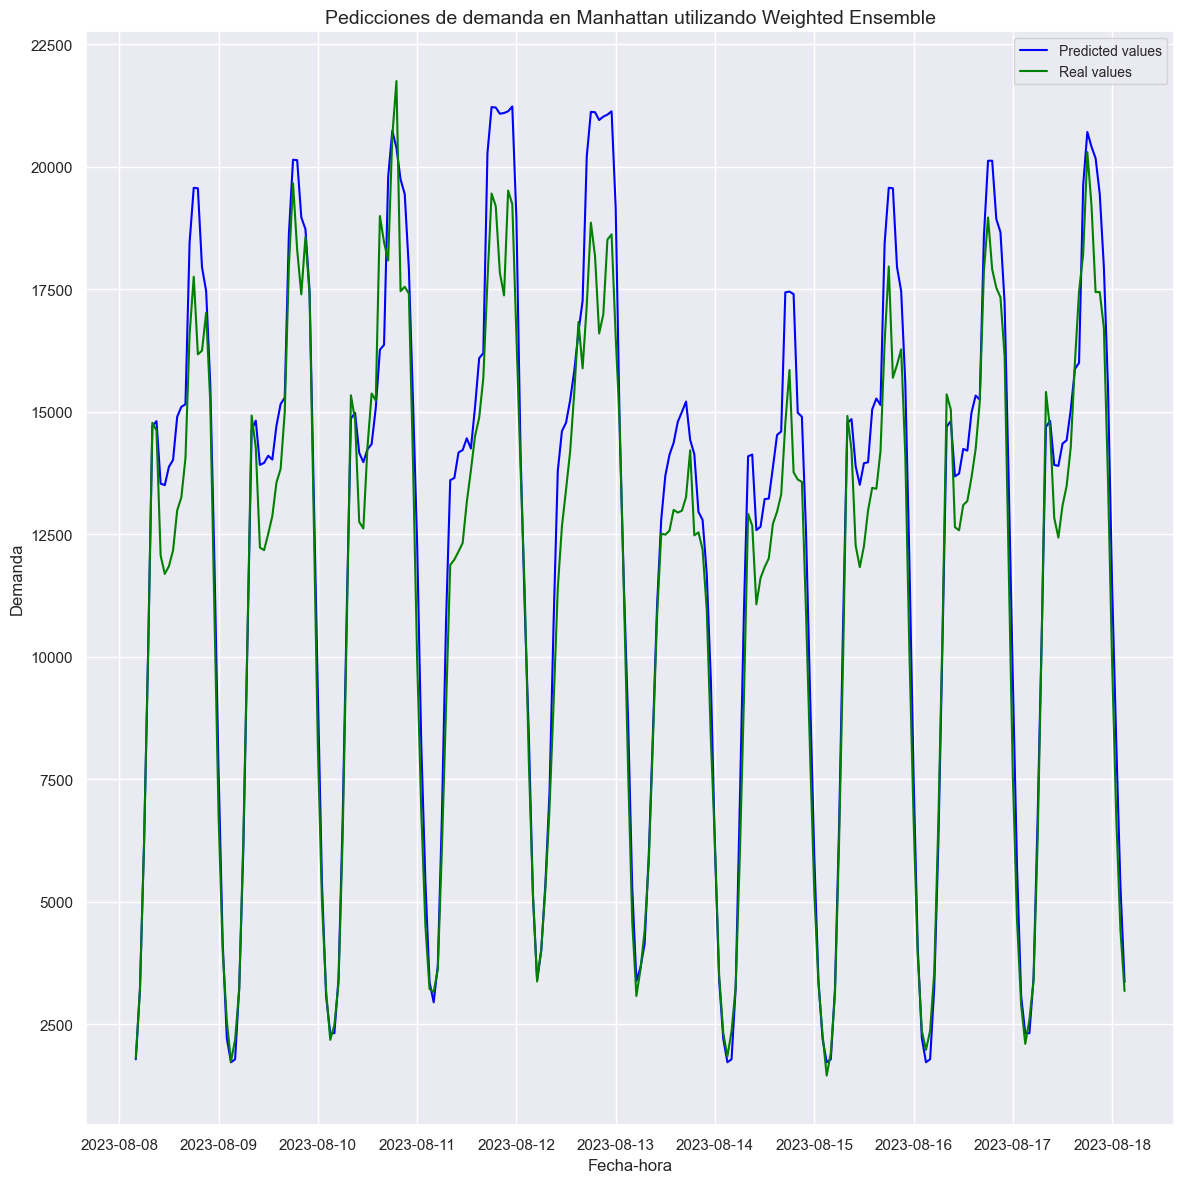

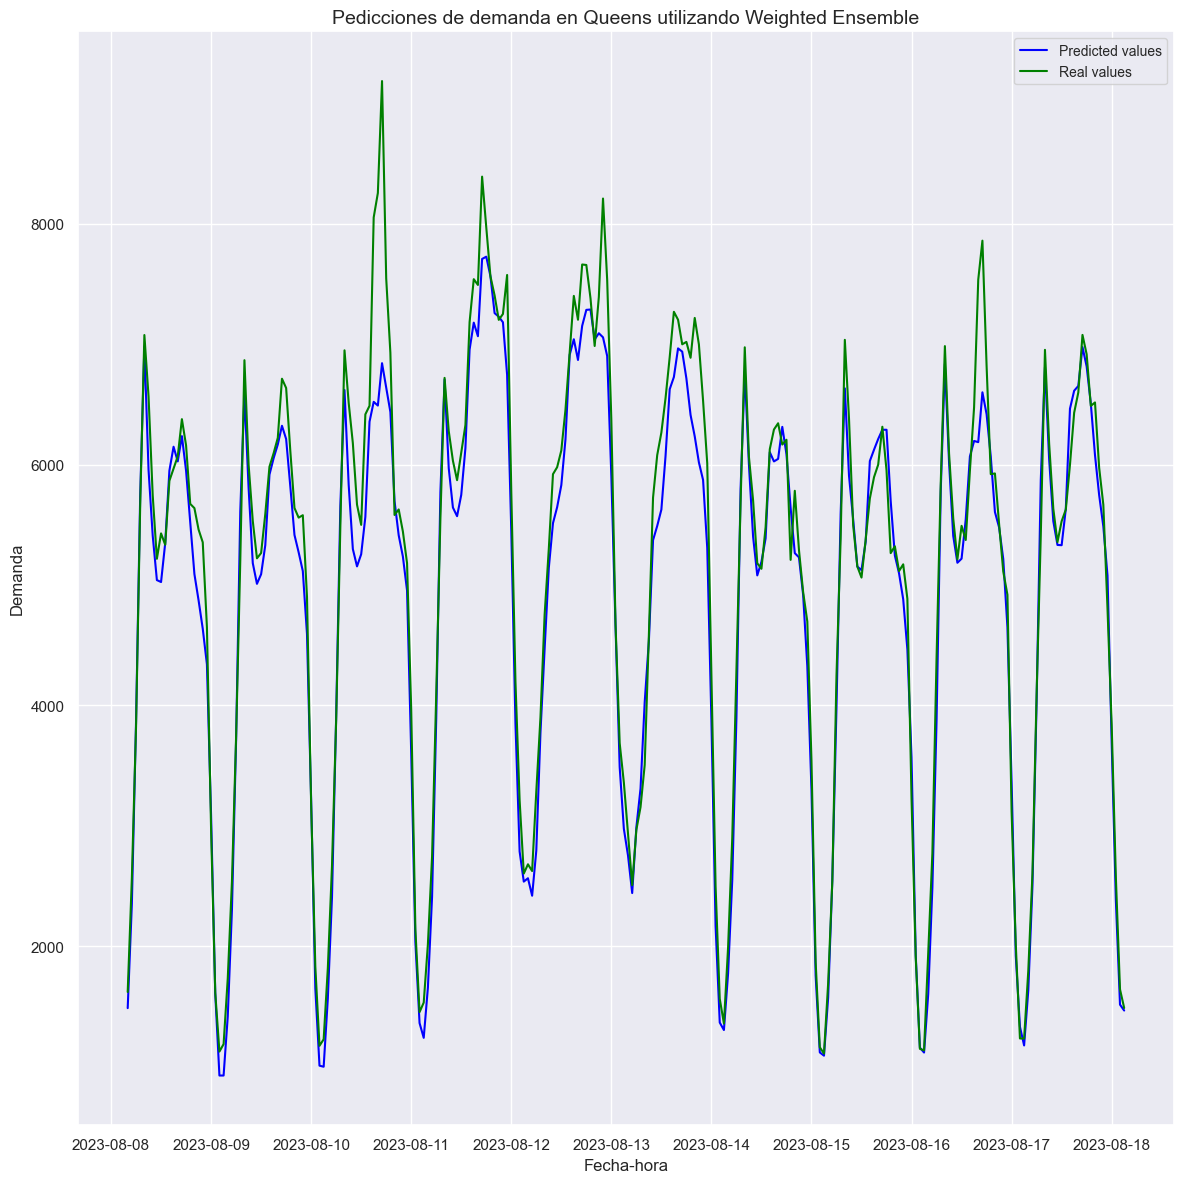

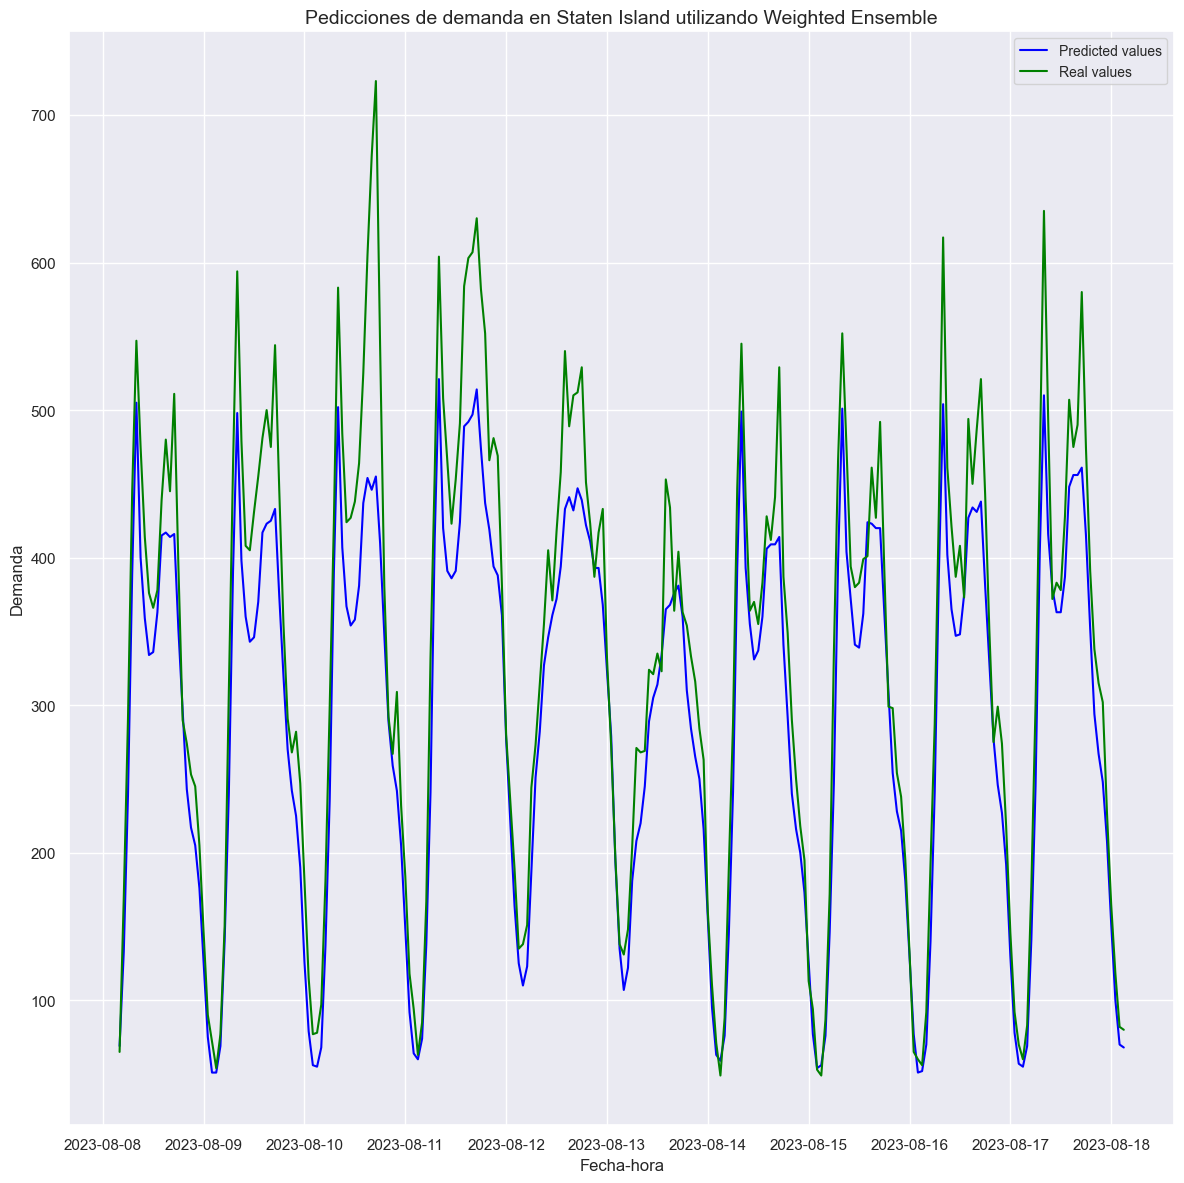

In [8]:
graficar_pred_ensemble(pred, 10)

In [8]:
nyc_pred = predecir(ensemble_completo['ensemble'], ponderacion='lineal')

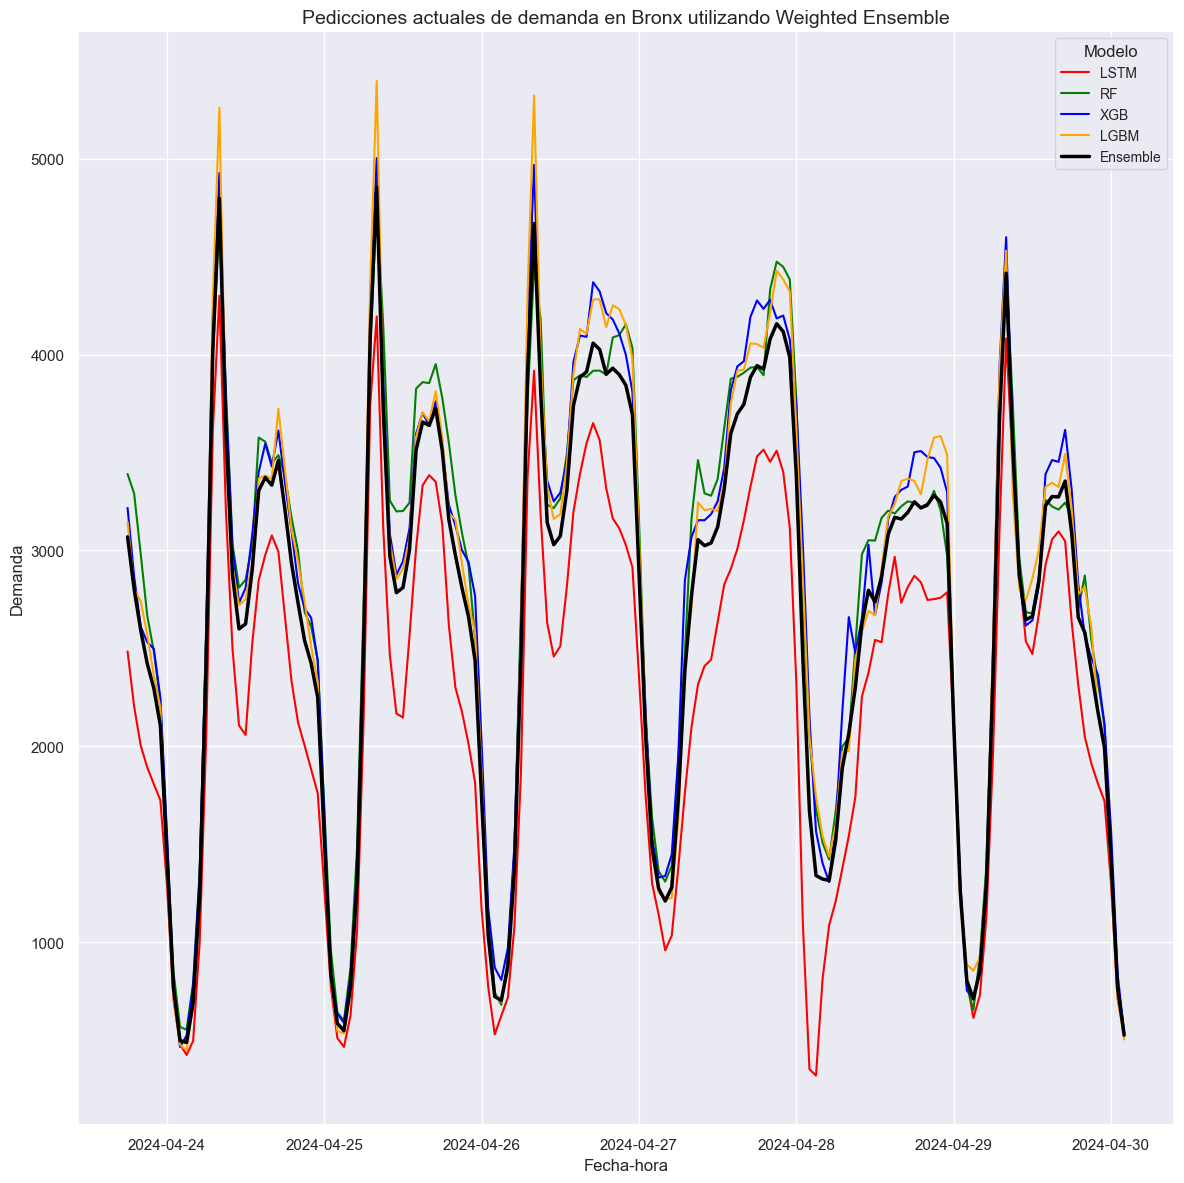

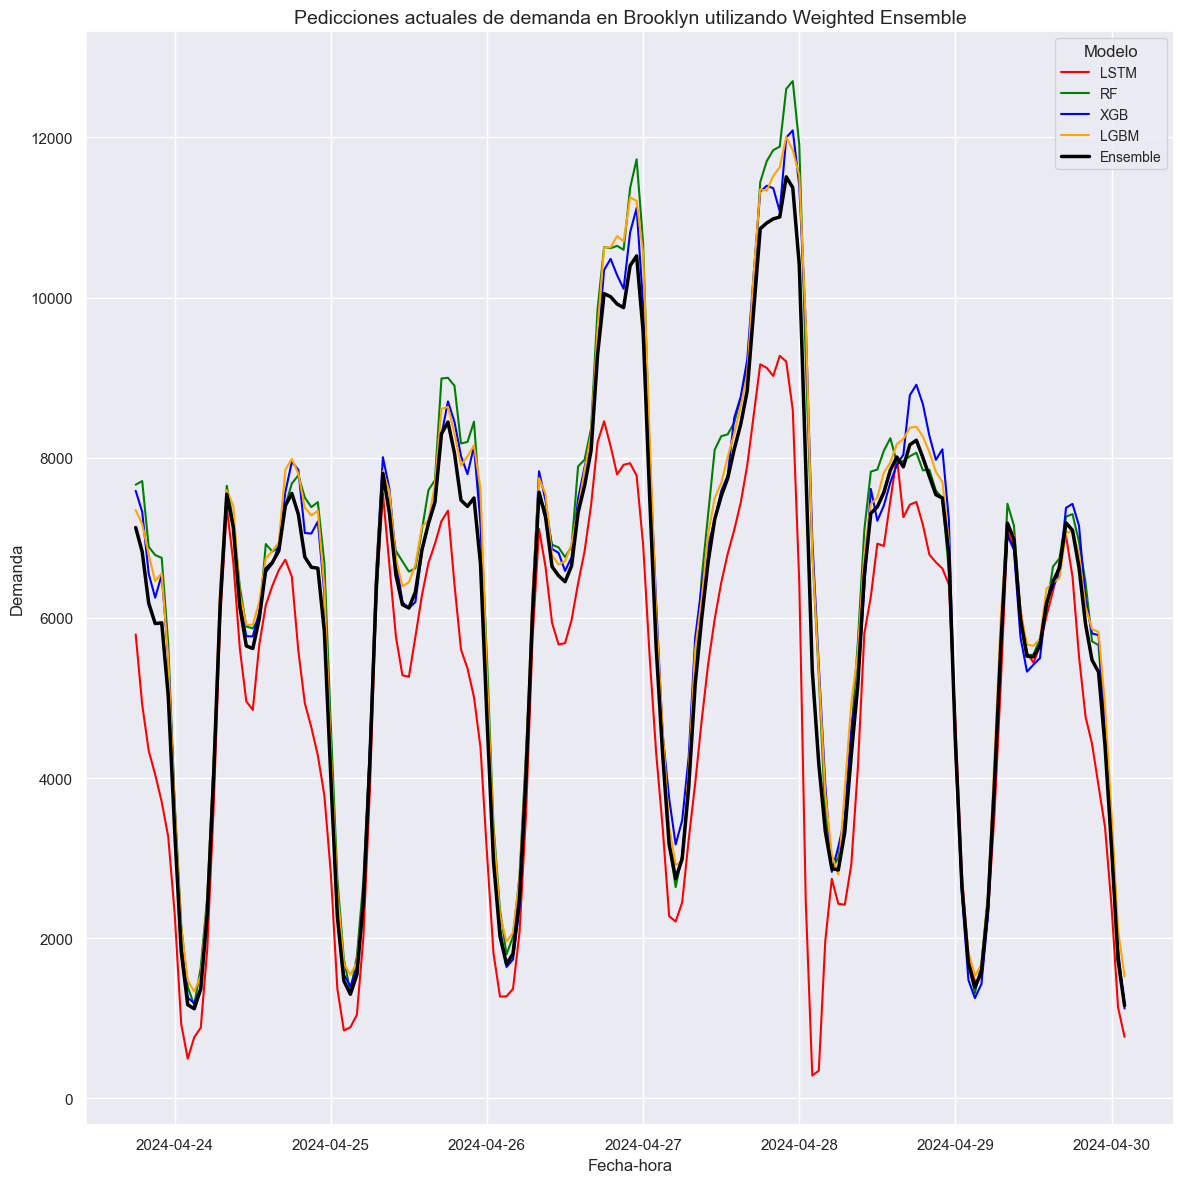

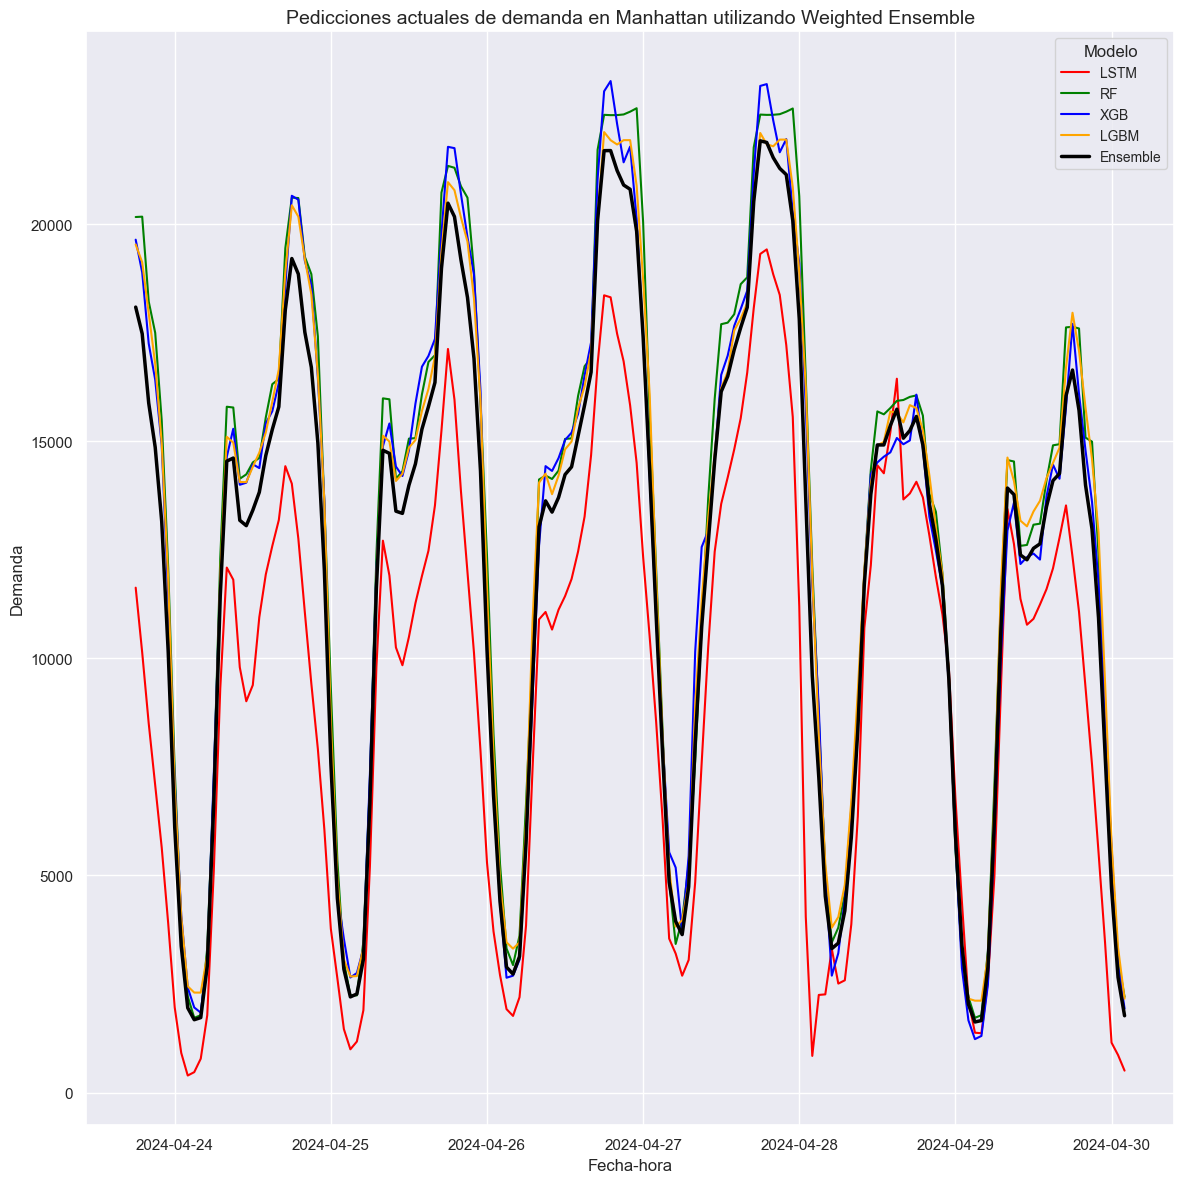

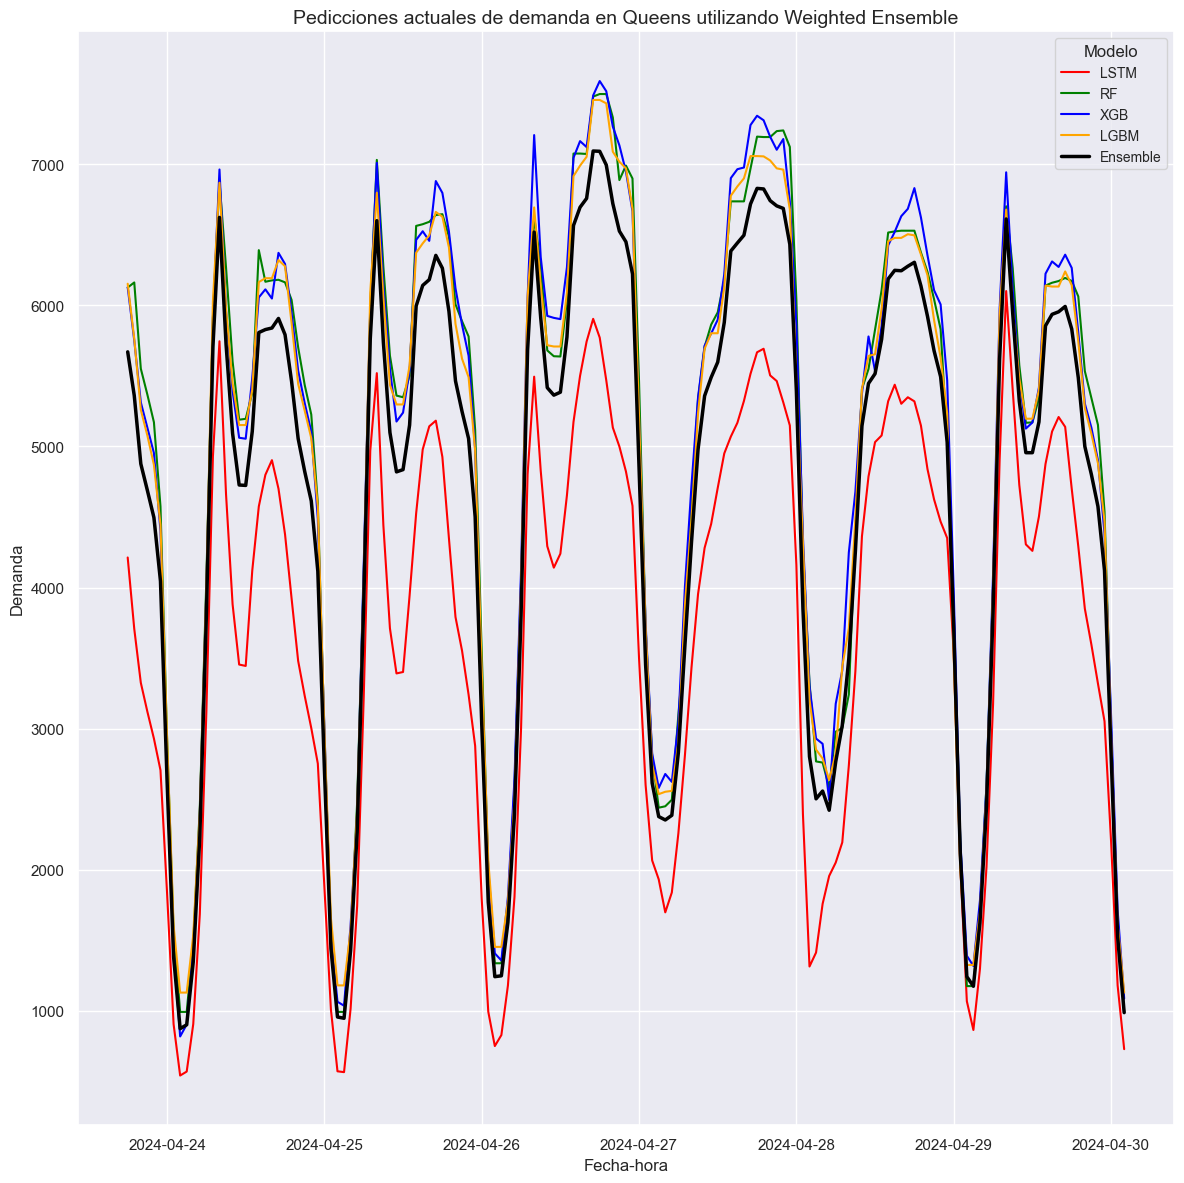

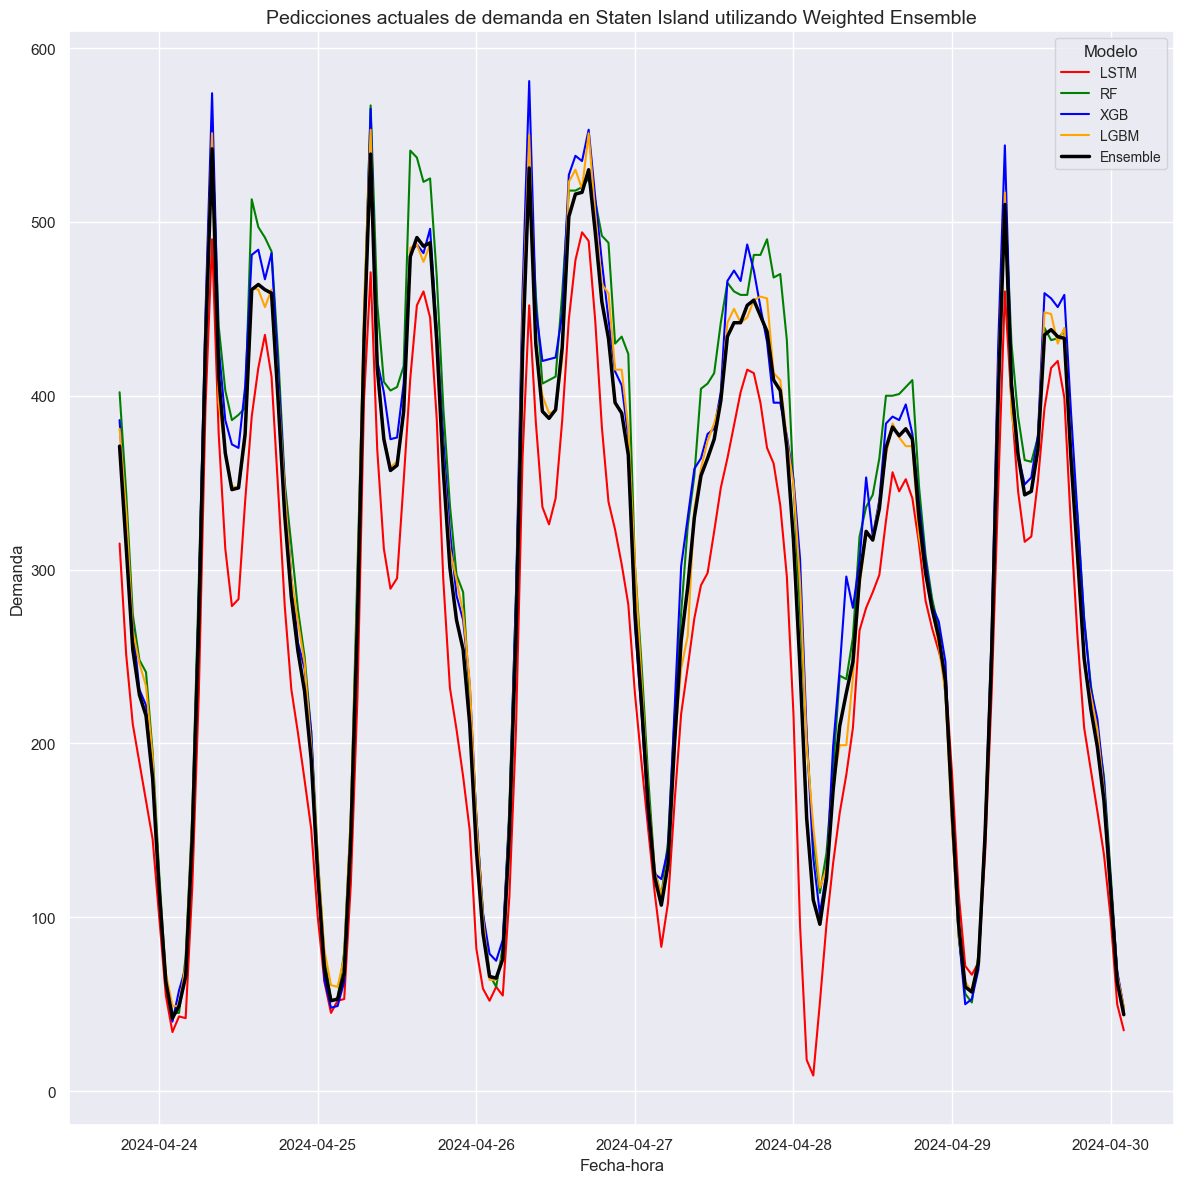

In [9]:
graficar_predicciones(nyc_pred)

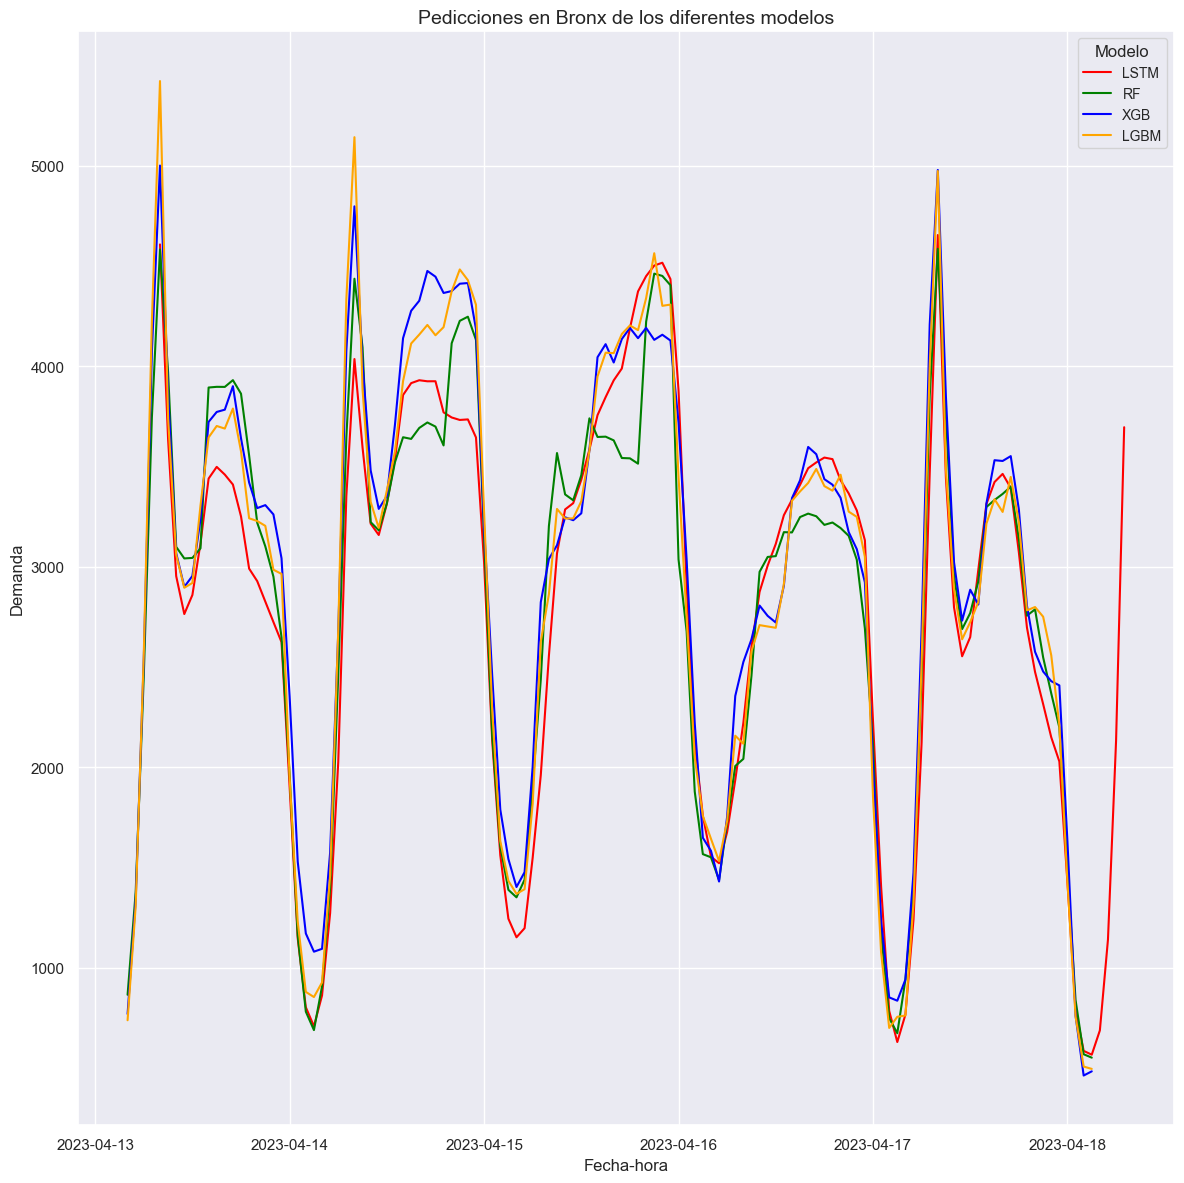

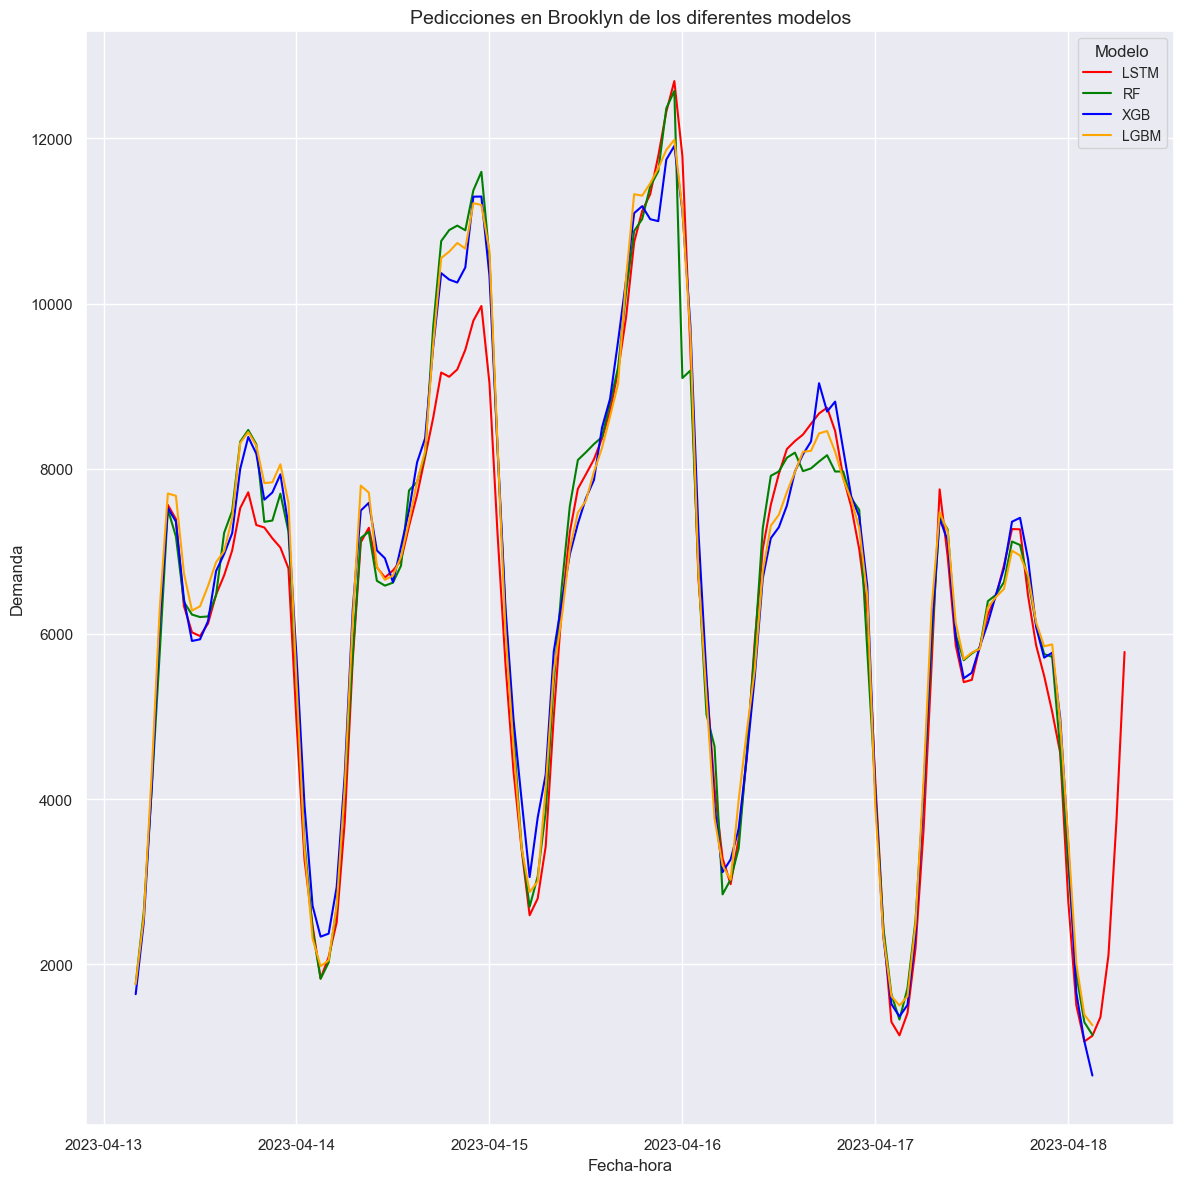

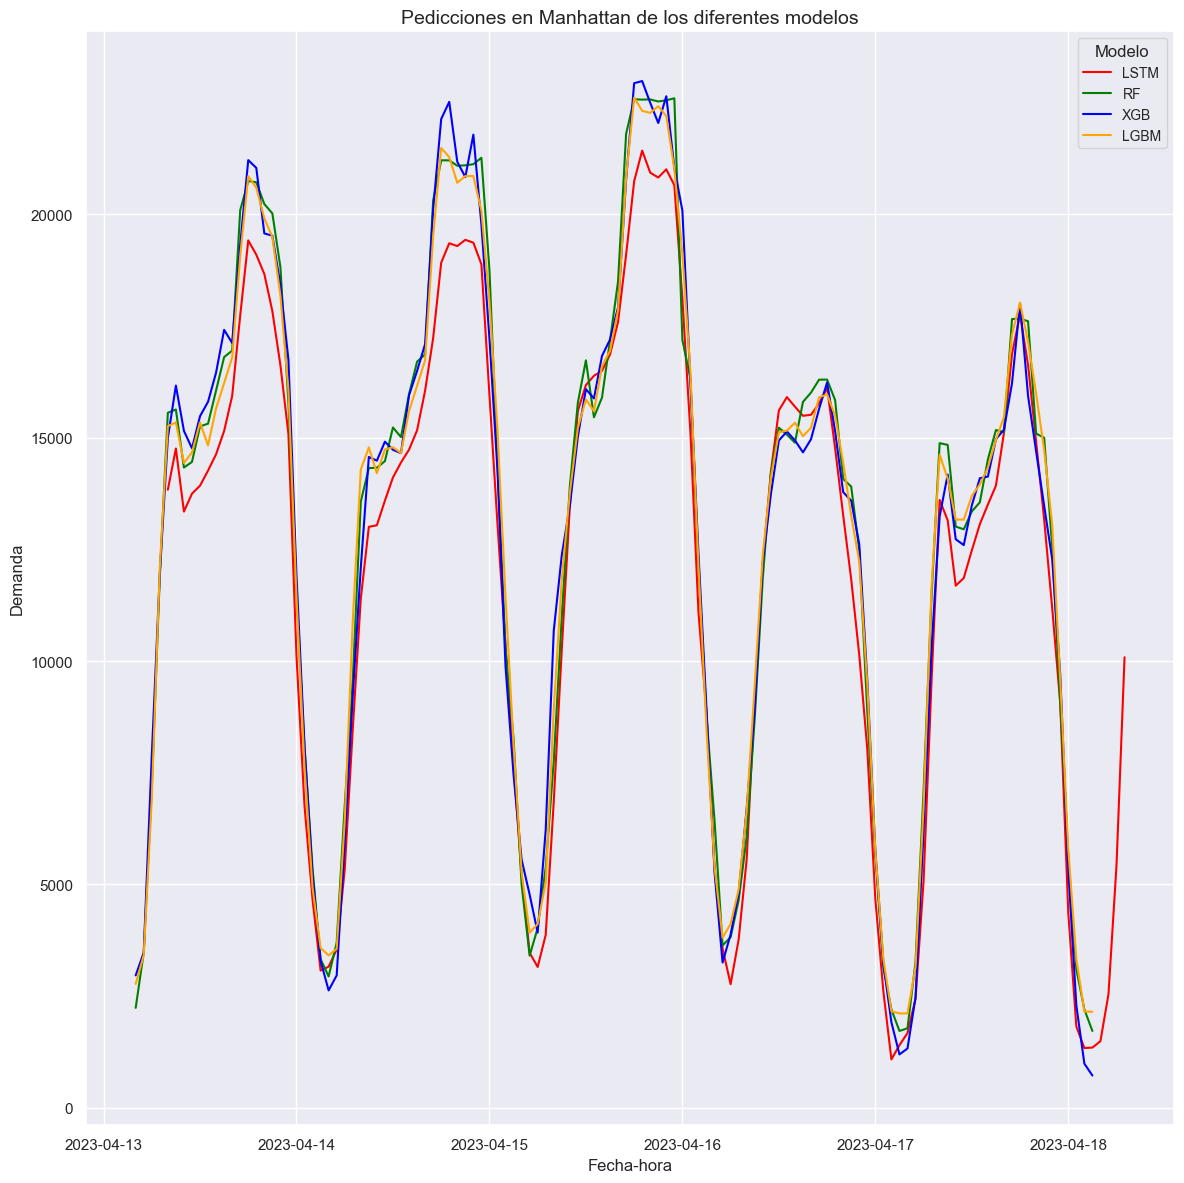

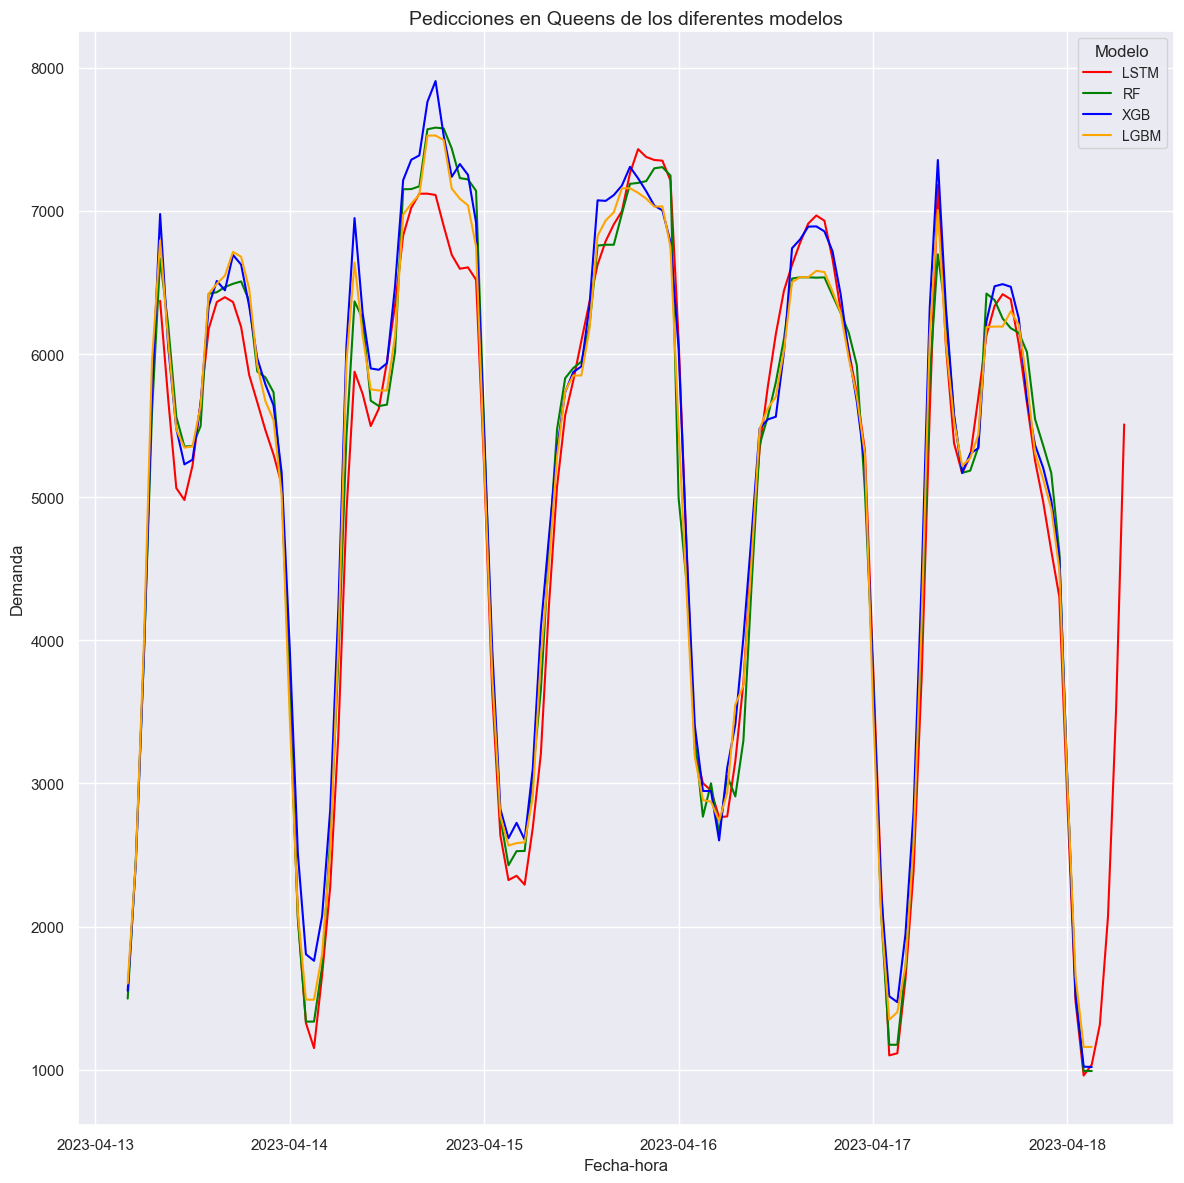

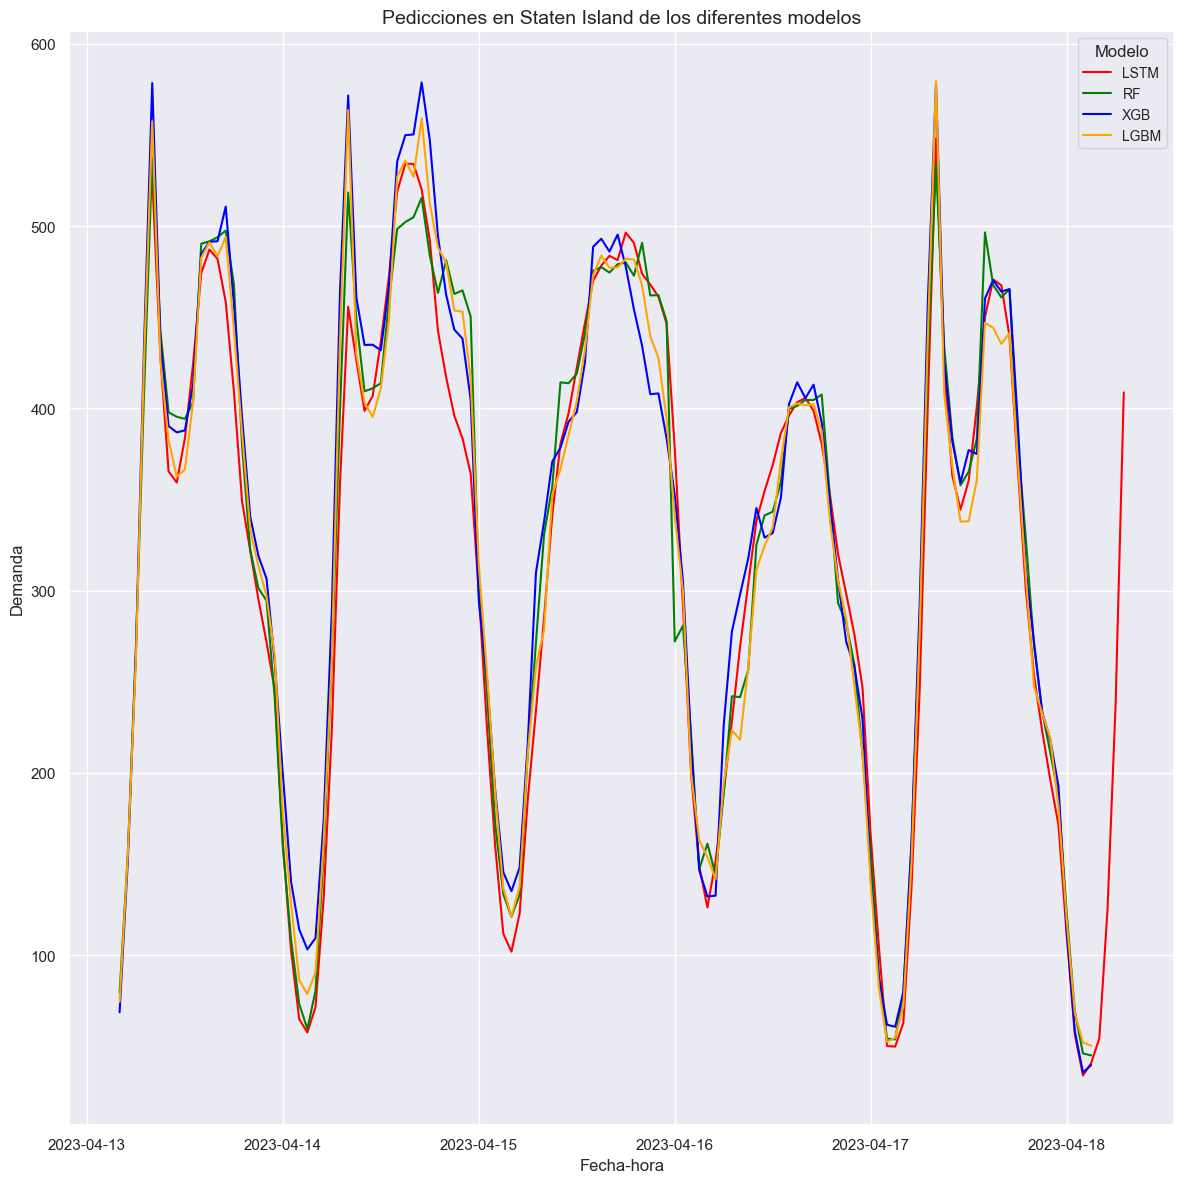

In [11]:
graficar_predicciones_modelos(ensemble,numero_dias=5)

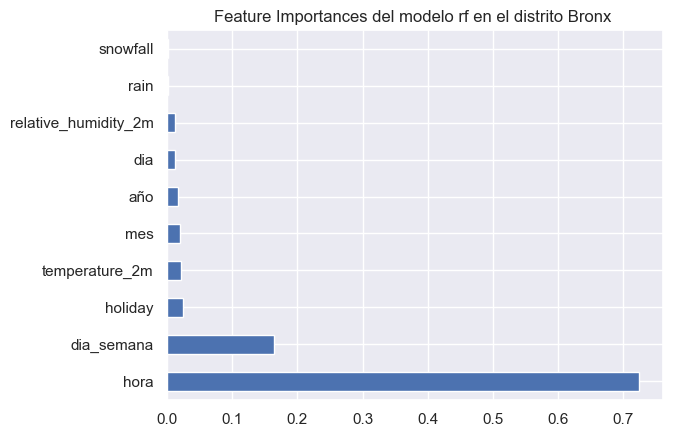

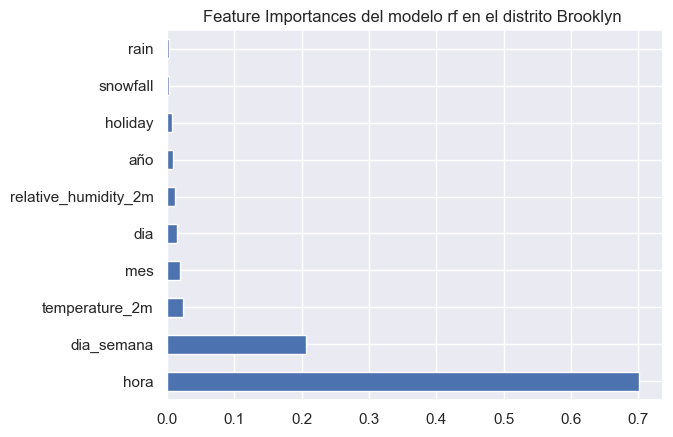

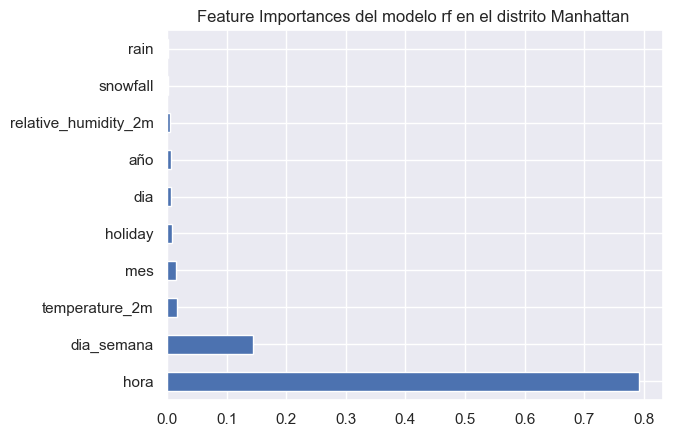

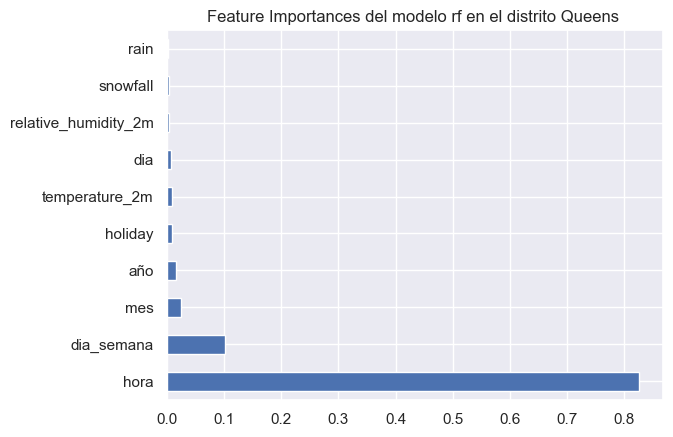

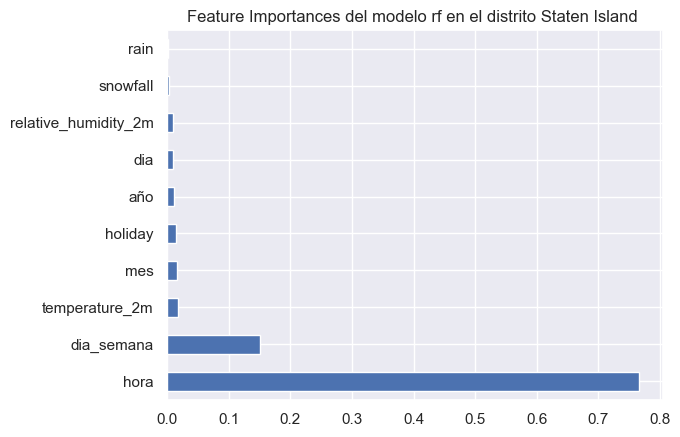

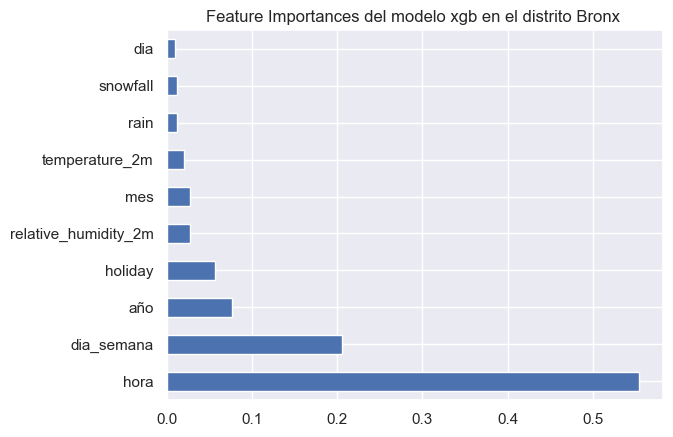

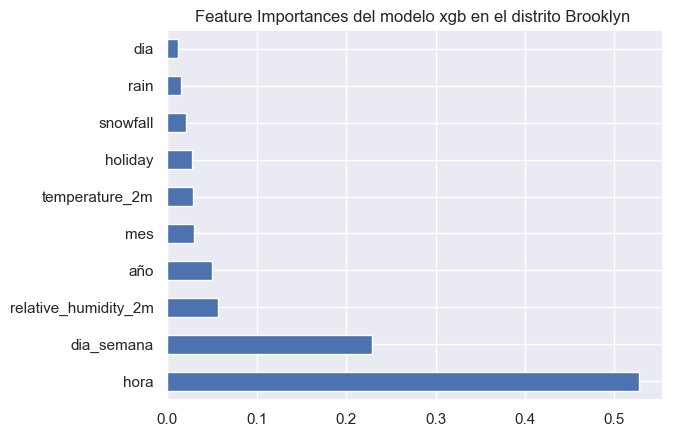

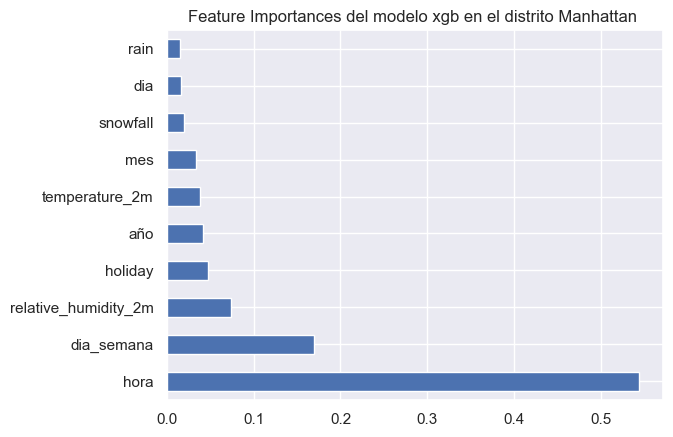

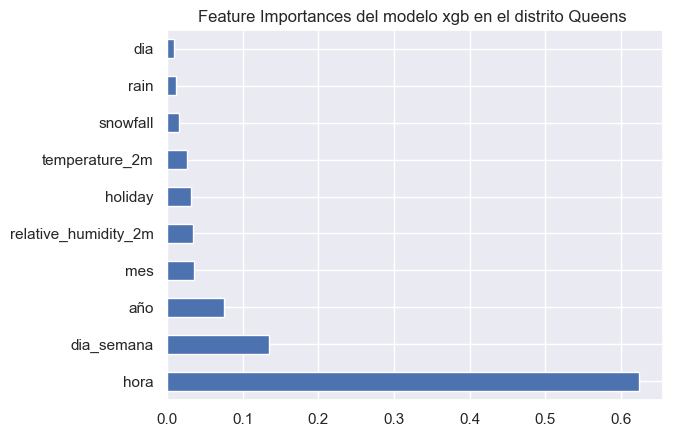

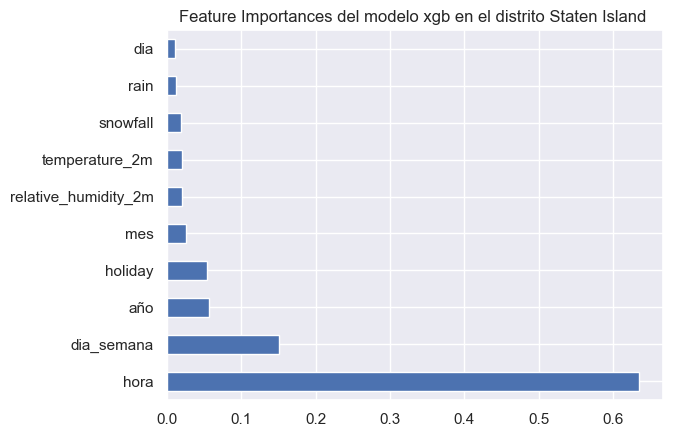

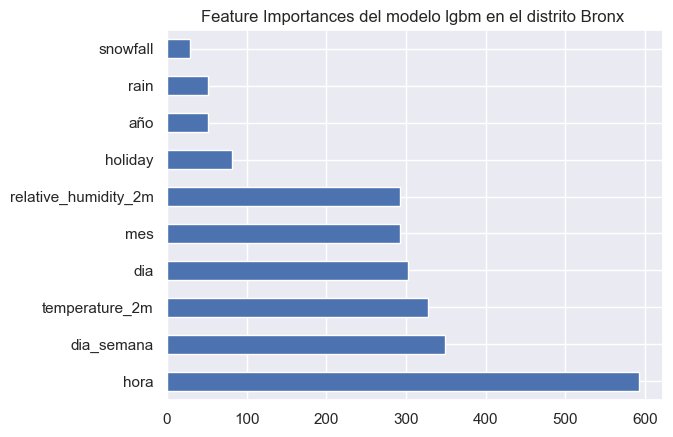

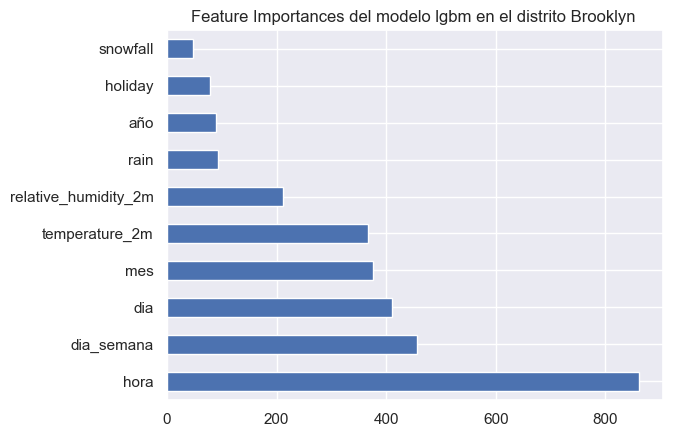

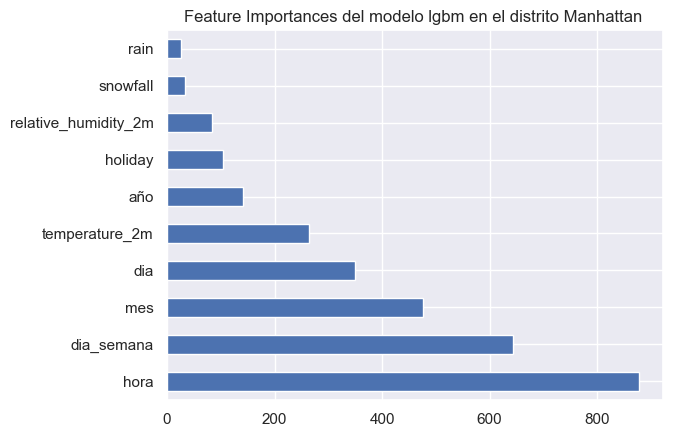

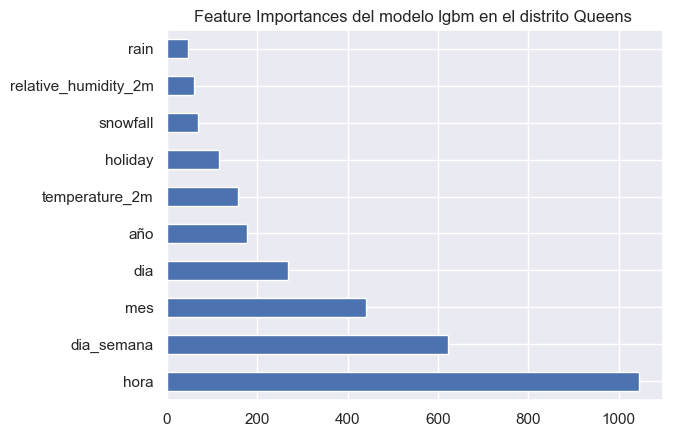

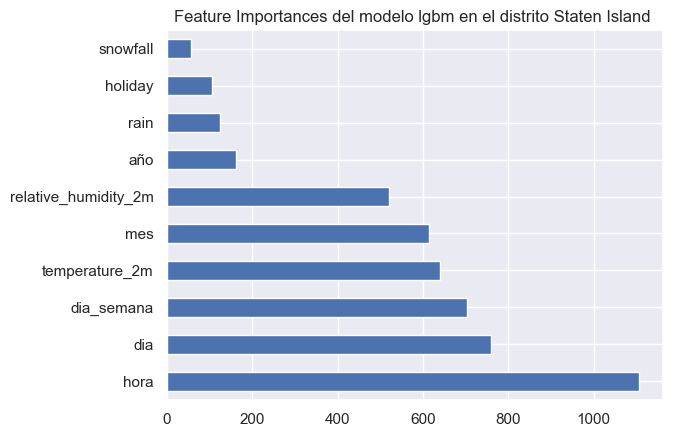

In [20]:
districts = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']
columnas_X = ['año', 'mes', 'dia', 'hora', 'dia_semana', 'holiday', 'temperature_2m', 'rain', 'relative_humidity_2m', 'snowfall']
models = ['rf', 'xgb', 'lgbm']
for model in models:
    for district in districts:
        temp_model = ensemble['models'][model][district]
        feature_importances = pd.Series(temp_model.feature_importances_, index=columnas_X)
        feature_importances.nlargest(10).plot(kind='barh')
        plt.title(f'Feature Importances del modelo {model} en el distrito {district} ')
        plt.show()


In [21]:
def graficar_predicciones_modelos(ensemble, numero_dias=5):
    '''
    Grafica las predicciones del set de testeo del entrenamiento de los distintos modelos correspondeintes al Ensemble.
    '''
    pred_modelos = ensemble['test_predictions']
    districts = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']
    for district in districts:
            
            plt.figure(figsize=(12,12))
            sns.set_style('darkgrid')
            sns.lineplot(pred_modelos['lstm'][district]['Predicted'][:numero_dias*24], label='LSTM', color='red')
            sns.lineplot(pred_modelos['rf'][district]['Predicted'][:numero_dias*24], label='RF', color='green')
            sns.lineplot(pred_modelos['xgb'][district]['Predicted'][:numero_dias*24], label='XGB', color='blue')
            sns.lineplot(pred_modelos['lgbm'][district]['Predicted'][:numero_dias*24], label='LGBM', color='orange')
            sns.lineplot(pred_modelos['lstm'][district]['Real values'][:numero_dias*24], label= 'Valores reales', color= 'black')
            plt.title(f'Pedicciones en {district} de los diferentes modelos en el set de testeo', fontsize=14)
            plt.xlabel('Fecha-hora', fontsize=12)
            plt.ylabel('Demanda', fontsize=12)
            plt.legend(title='Modelo', fontsize=10, title_fontsize='12')
            plt.tight_layout()
            plt.show()


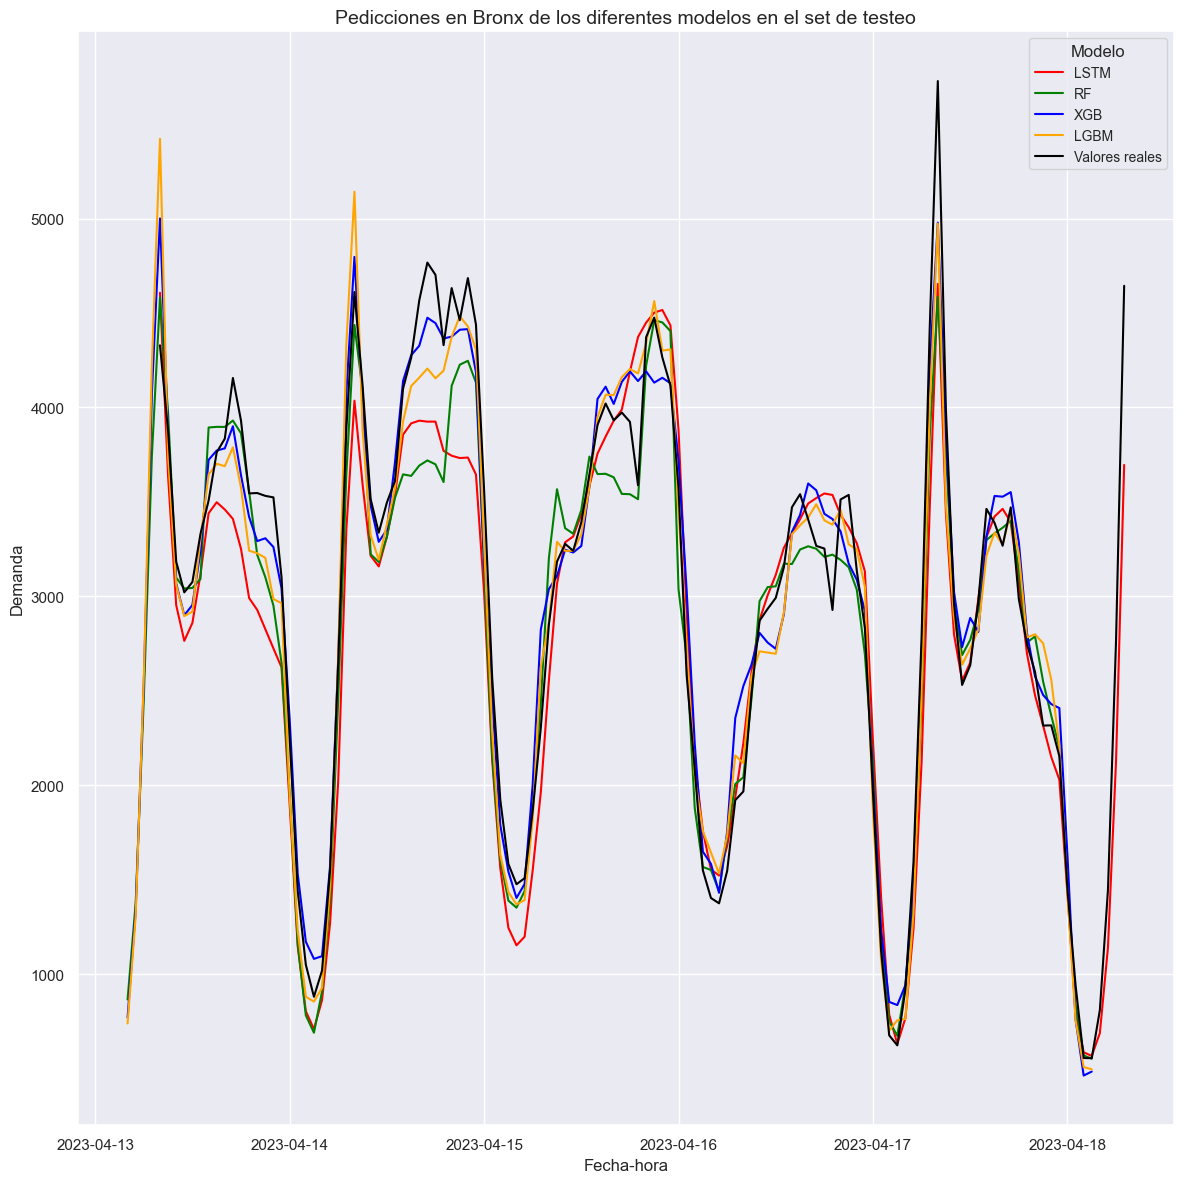

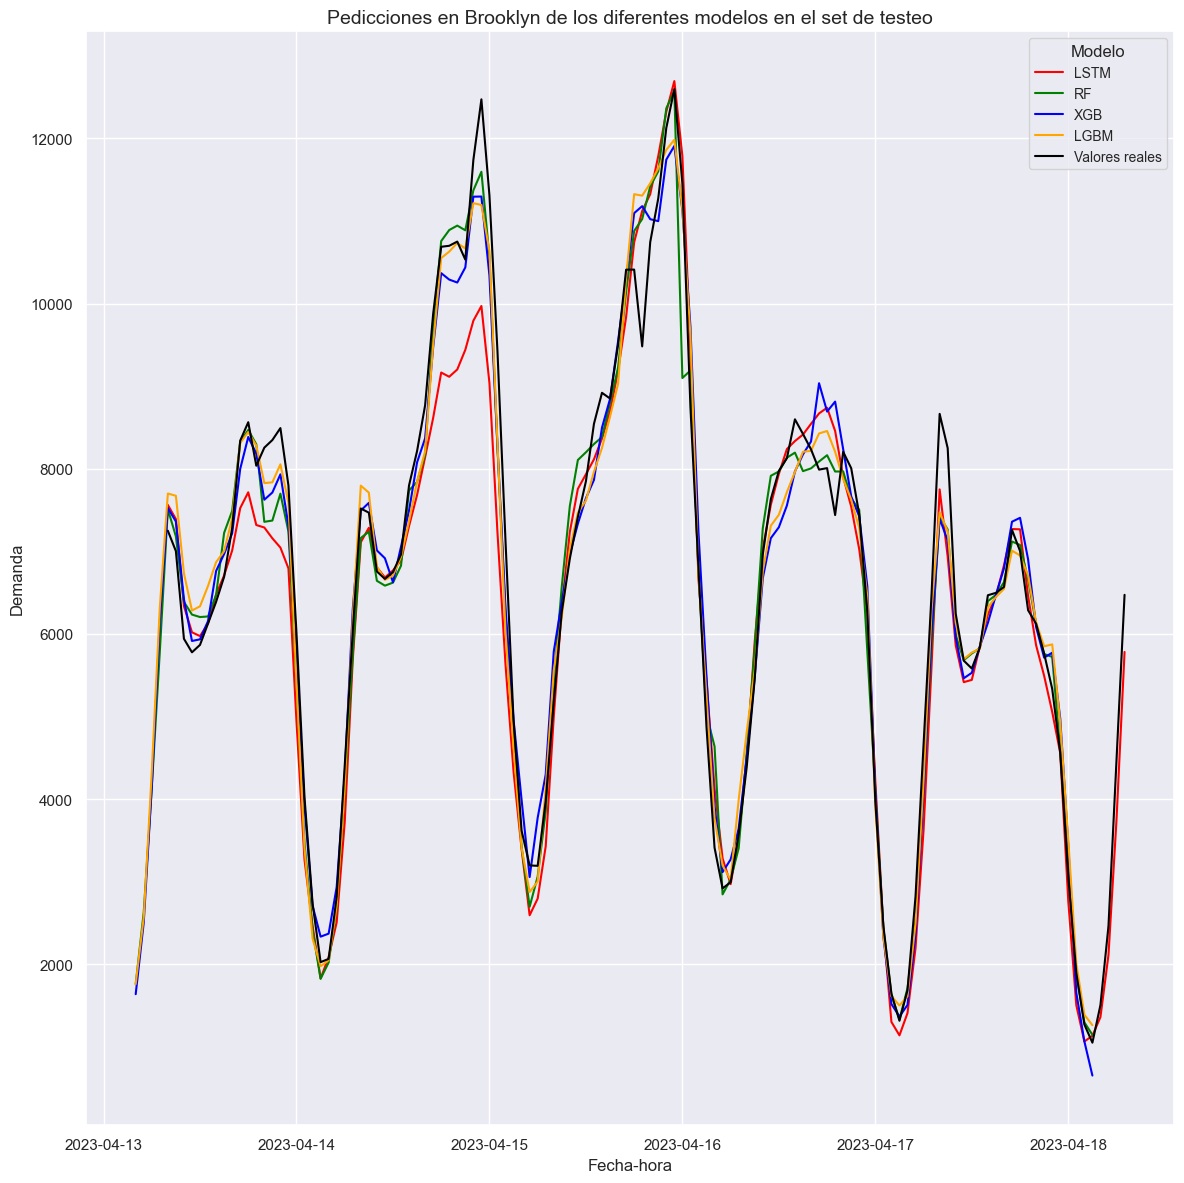

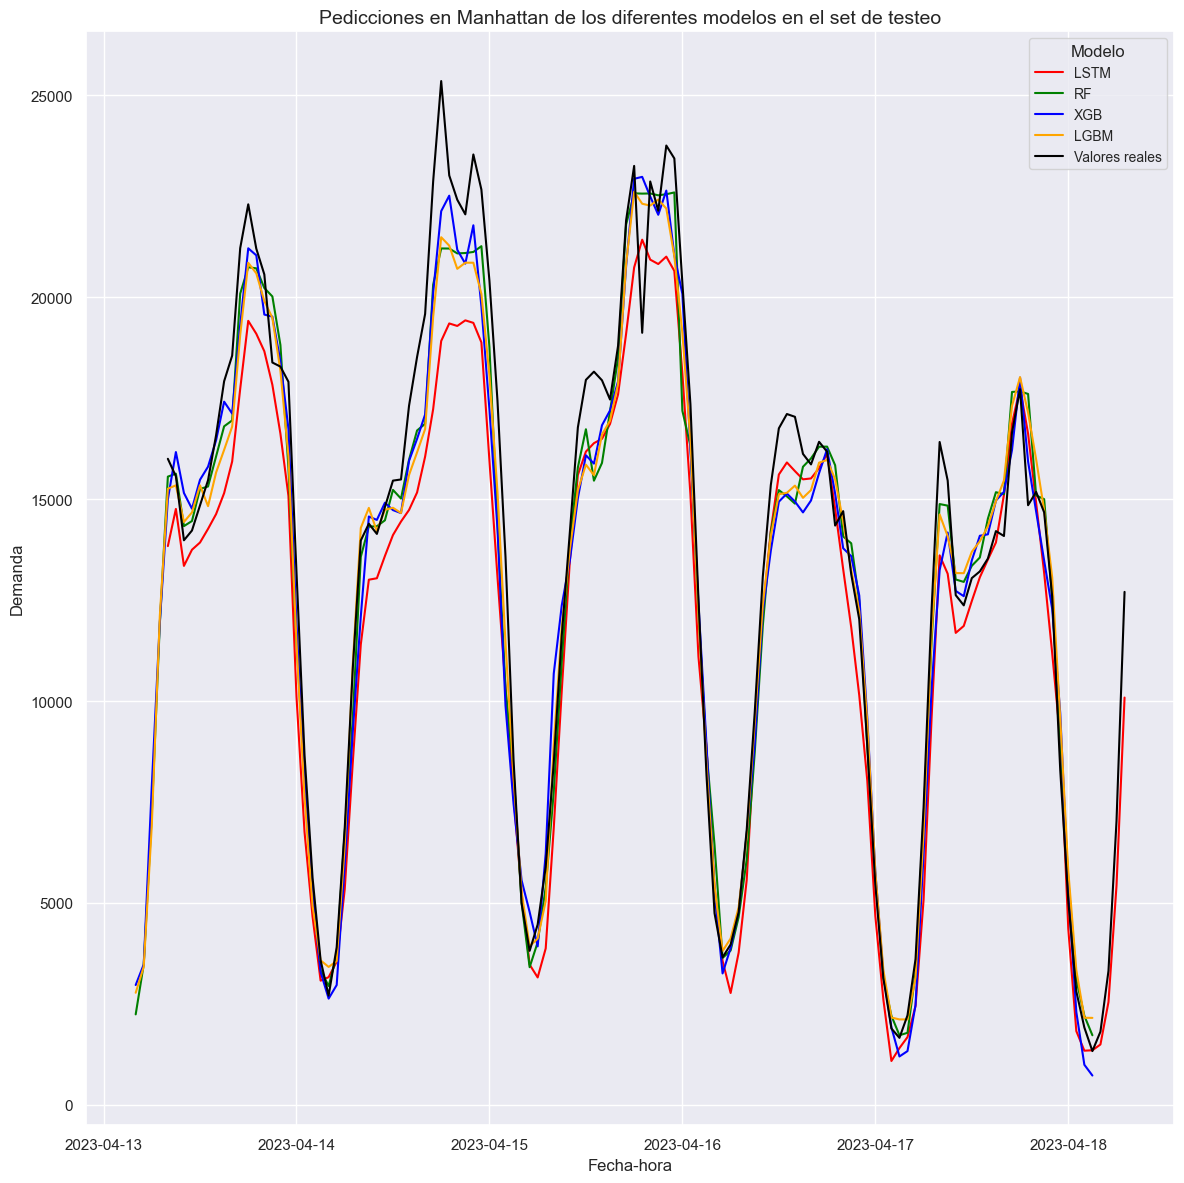

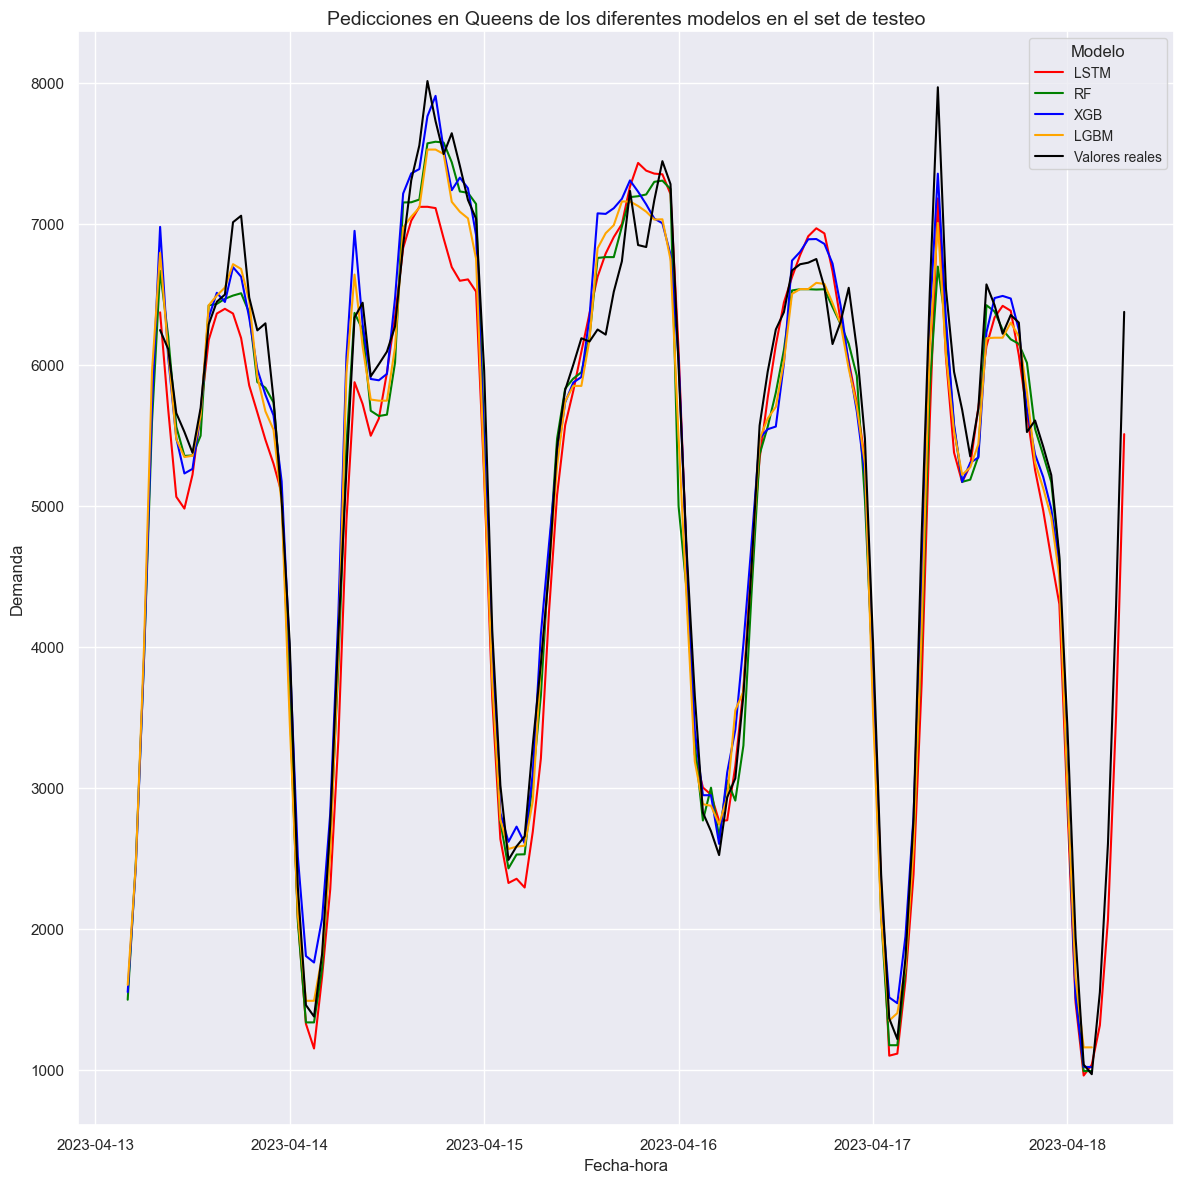

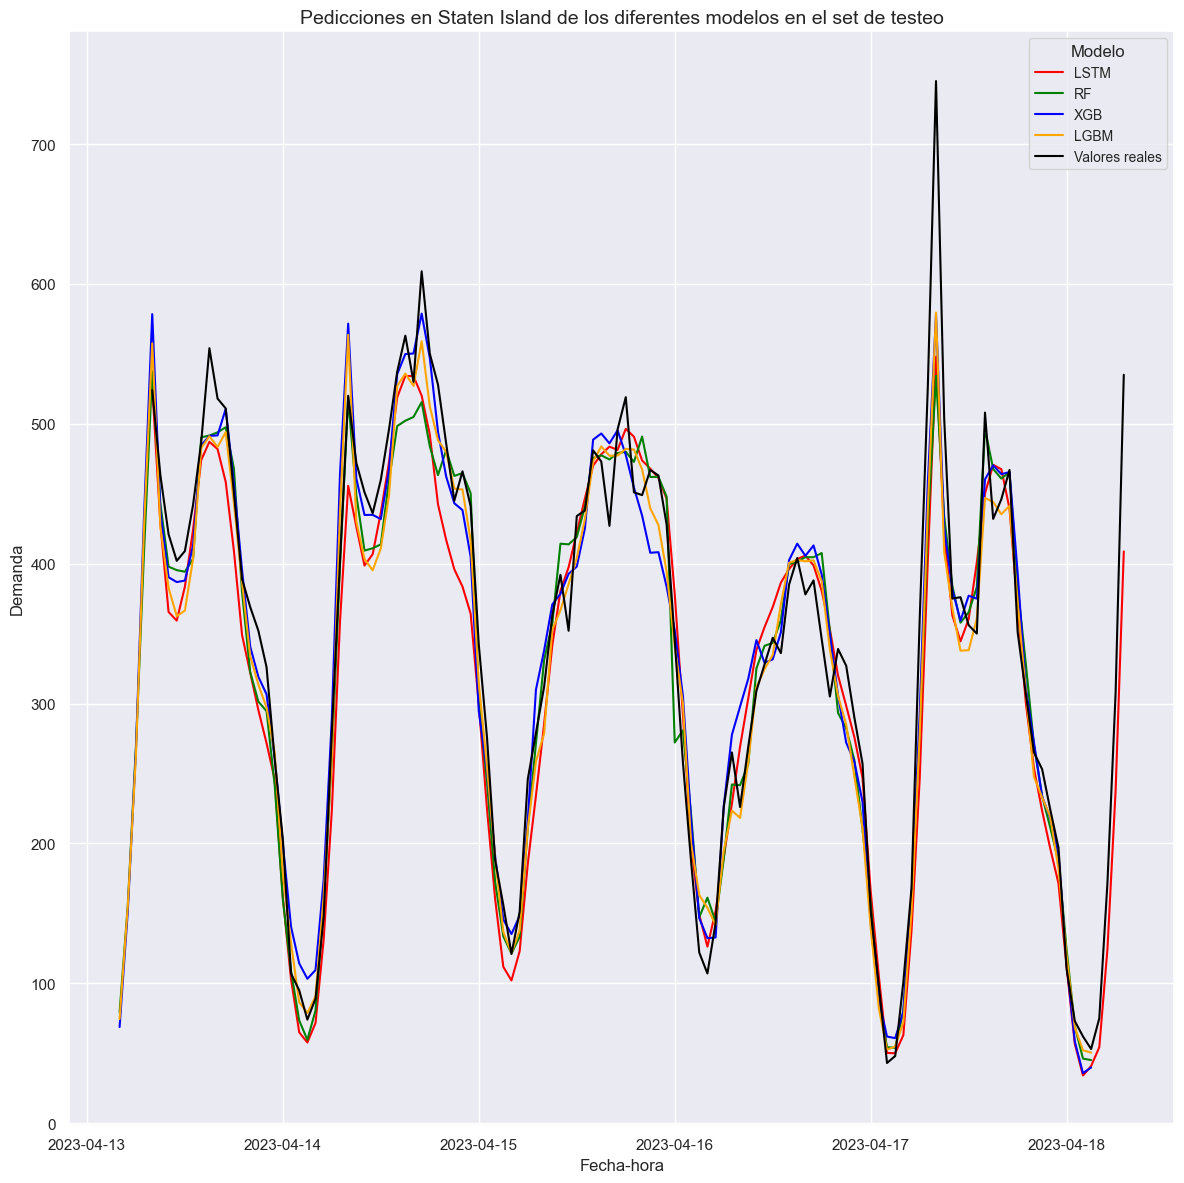

In [22]:
graficar_predicciones_modelos(ensemble)